# Loading Data/Libraries

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("SPX_database_2010.xlsx")
df_total_ret = pd.read_excel("SPX_database_2010.xlsx", sheet_name="total_ret")
df_price = pd.read_excel("SPX_database_2010.xlsx", sheet_name="prices")


In [4]:
import matplotlib.pyplot as plt

# Choosing 30 random companies that existed from 2015-2024

In [29]:
# Convert Dates column to datetime
df_total_ret["Dates"] = pd.to_datetime(df_total_ret["Dates"])
df_price["Dates"] = pd.to_datetime(df_price["Dates"])

# Filter data for 2015-2024
mask = (df_total_ret["Dates"] >= "2015-01-01") & (df_total_ret["Dates"] <= "2024-12-31")
df_filtered = df_total_ret.loc[mask]

# Drop the Dates column to focus only on companies
df_companies = df_filtered.drop(columns=["Dates"])

# Keep only companies with NO NaN in that period
valid_companies = df_companies.columns[df_companies.notna().all()]

# Randomly choose 30 companies
np.random.seed(41)  
selected_companies = np.random.choice(valid_companies, size=30, replace=False)

print("Selected companies:")
print(selected_companies)


Selected companies:
['WAB UN Equity' 'TFC UN Equity.1' 'LKQ UW Equity.1' 'RSG UN Equity'
 'CMS UN Equity.1' 'APTV UN Equity.1' 'IDXX UW Equity.1' 'RMD UN Equity'
 'PNR UN Equity.1' 'FAST UW Equity.1' 'TTWO UW Equity' 'NWSA UW Equity'
 'GOOG UW Equity' 'NRG UN Equity' 'SYK UN Equity.1' 'CTRA UN Equity'
 'WM UN Equity' 'TMO UN Equity.1' 'CAG UN Equity.1' 'NOW UN Equity.1'
 'NDAQ UW Equity' 'KEY UN Equity.1' 'HUBB UN Equity.1' 'CRM UN Equity.1'
 'ROK UN Equity.1' 'MNST UW Equity' 'AEE UN Equity.1' 'LVS UN Equity'
 'AMGN UW Equity.1' 'ZTS UN Equity']


# Collect daily returns for selected companies and EW & VW portfolios


In [30]:
# --- Step 1: Filter only the 30 selected companies (from earlier step) ---
df_prices_selected = df_price[["Dates"] + list(selected_companies)]

# --- Step 2: Keep only 2015–2024 ---
mask = (df_prices_selected["Dates"] >= "2015-01-01") & (df_prices_selected["Dates"] <= "2024-12-31")
df_prices_filtered = df_prices_selected.loc[mask].set_index("Dates")

# --- Step 3: Compute daily log returns ---
df_returns = np.log(df_prices_filtered / df_prices_filtered.shift(1)).dropna()

# --- Step 4: Equally weighted portfolio return ---
df_returns["Equal_Weighted_Portfolio"] = df_returns.mean(axis=1)

# --- Final check ---
print(df_returns.head())

            WAB UN Equity  TFC UN Equity.1  LKQ UW Equity.1  RSG UN Equity  \
Dates                                                                        
2015-01-02       0.002529        -0.006190        -0.012165       0.007919   
2015-01-05      -0.022875        -0.032074        -0.012497      -0.005685   
2015-01-06      -0.013004        -0.019696        -0.017836       0.003464   
2015-01-07       0.009710         0.013263         0.014002      -0.003464   
2015-01-08       0.020297         0.016534         0.010555       0.009130   

            CMS UN Equity.1  APTV UN Equity.1  IDXX UW Equity.1  \
Dates                                                             
2015-01-02         0.011161         -0.001790         -0.006360   
2015-01-05        -0.008287         -0.044651         -0.006947   
2015-01-06         0.001720         -0.006359          0.003207   
2015-01-07         0.016196          0.007942          0.019966   
2015-01-08         0.005341          0.024297      

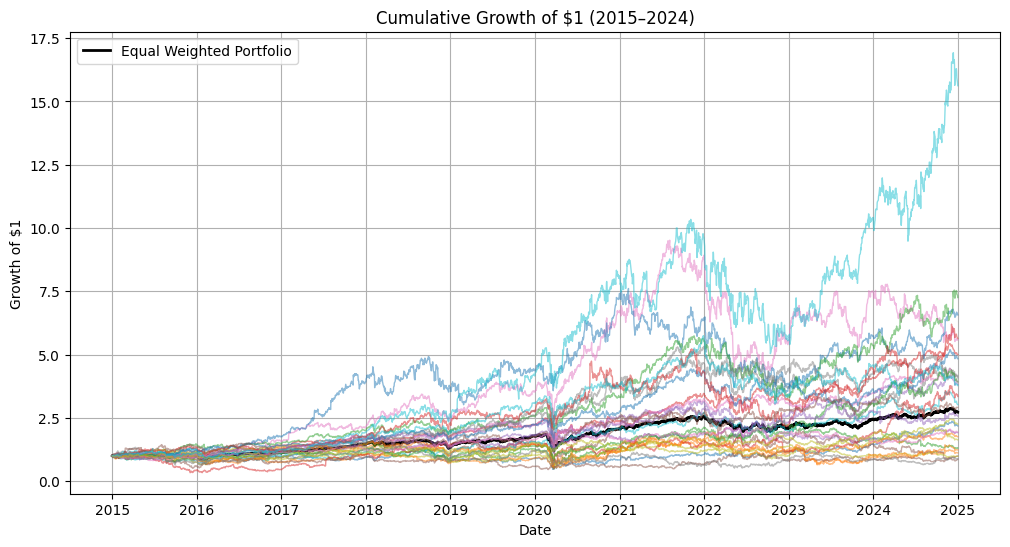

In [31]:
df_cum_returns = np.exp(df_returns.cumsum())

# --- Step 6: Plot cumulative growth of $1 ---
plt.figure(figsize=(12,6))
plt.plot(df_cum_returns.index, df_cum_returns["Equal_Weighted_Portfolio"], label="Equal Weighted Portfolio", linewidth=2, color="black")

# Optional: plot individual companies (light lines)
for col in selected_companies:
    plt.plot(df_cum_returns.index, df_cum_returns[col], alpha=0.5, linewidth=1)

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
df_mktcap = pd.read_excel("SPX_database_2010.xlsx", sheet_name="mkt_cap")

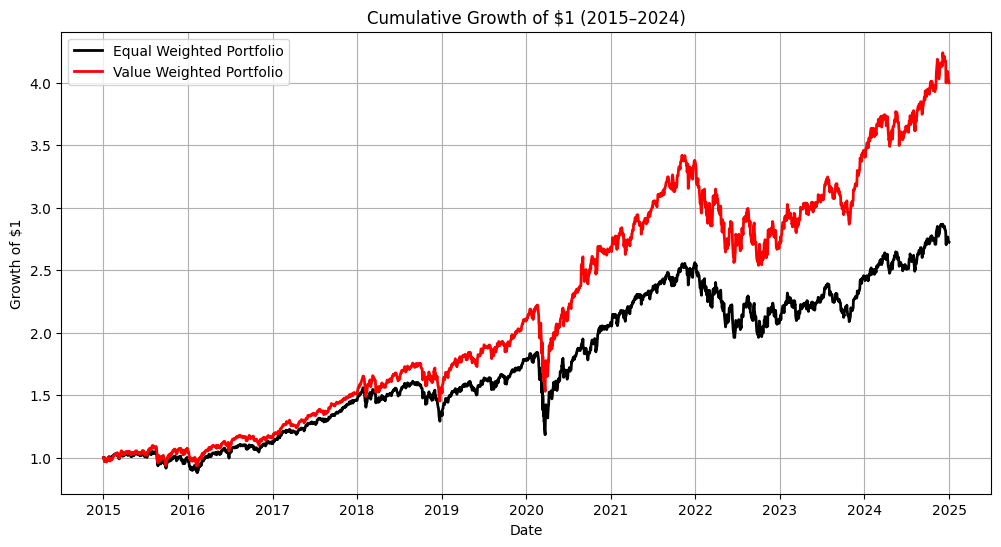

In [33]:
# Load market cap sheet
df_mktcap["Dates"] = pd.to_datetime(df_mktcap["Dates"])

# Keep only Dates + selected companies
df_mktcap_selected = df_mktcap[["Dates"] + list(selected_companies)]

# Filter to 2015–2024
mask = (df_mktcap_selected["Dates"] >= "2015-01-01") & (df_mktcap_selected["Dates"] <= "2024-12-31")
df_mktcap_filtered = df_mktcap_selected.loc[mask].set_index("Dates")

# Align with returns dataframe (important!)
df_mktcap_filtered = df_mktcap_filtered.loc[df_returns.index]

# --- Step 1: Compute weights (row-wise normalization) ---
weights = df_mktcap_filtered.div(df_mktcap_filtered.sum(axis=1), axis=0)

# --- Step 2: Value-weighted portfolio return ---
# Multiply each stock's return by its weight, then sum across columns
vw_returns = (df_returns[selected_companies] * weights).sum(axis=1)

# Add to dataframe
df_returns["Value_Weighted_Portfolio"] = vw_returns

# --- Step 3: Compute cumulative returns (growth of $1) ---
df_cum_returns = np.exp(df_returns.cumsum())

# --- Step 4: Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns.index, df_cum_returns["Equal_Weighted_Portfolio"], label="Equal Weighted Portfolio", linewidth=2, color="black")
plt.plot(df_cum_returns.index, df_cum_returns["Value_Weighted_Portfolio"], label="Value Weighted Portfolio", linewidth=2, color="red")

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


# Rebalance

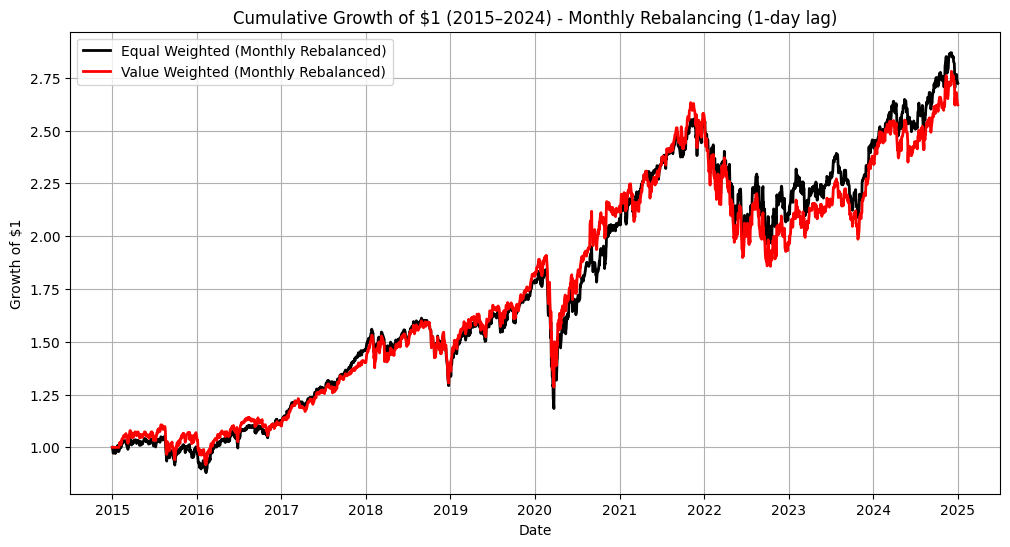

In [34]:
selected = list(selected_companies)  # just for shorter notation

# --- Step 1: Compute daily lagged market cap weights ---
weights_daily = df_mktcap_filtered.div(df_mktcap_filtered.sum(axis=1), axis=0)
weights_daily = weights_daily.shift(1)   # 1-day lag so we don't use future info

# --- Step 2: Identify first trading day of each month ---
first_days = df_returns.groupby([df_returns.index.year, df_returns.index.month]).apply(lambda x: x.index[0])

# --- Step 3: Extract weights for rebalancing dates ---
vw_monthly_weights = weights_daily.loc[first_days]

# Forward-fill weights to all days until next rebalance
vw_monthly_weights = vw_monthly_weights.reindex(df_returns.index, method="ffill")

# --- Step 4: Value-weighted portfolio returns ---
vw_portfolio = (df_returns[selected] * vw_monthly_weights).sum(axis=1)

# --- Step 5: Equal-weight portfolio ---
n = len(selected)
ew_monthly_weights = pd.DataFrame(1/n, index=first_days, columns=selected)
ew_monthly_weights = ew_monthly_weights.reindex(df_returns.index, method="ffill")

ew_portfolio = (df_returns[selected] * ew_monthly_weights).sum(axis=1)

# --- Step 6: Add to returns DataFrame ---
df_returns["VW_Rebalanced"] = vw_portfolio
df_returns["EW_Rebalanced"] = ew_portfolio

# --- Step 7: Compute cumulative growth of $1 ---
df_cum = np.exp(df_returns.cumsum())

# --- Step 8: Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_cum.index, df_cum["EW_Rebalanced"], label="Equal Weighted (Monthly Rebalanced)", color="black", linewidth=2)
plt.plot(df_cum.index, df_cum["VW_Rebalanced"], label="Value Weighted (Monthly Rebalanced)", color="red", linewidth=2)

plt.title("Cumulative Growth of $1 (2015–2024) - Monthly Rebalancing (1-day lag)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

# Portfolio turnover

In [35]:
# Convert log returns to normal returns
df_simple_returns = np.exp(df_returns[selected]) - 1

def compute_turnover_with_drift(returns, target_weights):
    """
    returns: DataFrame of daily simple returns (not logs!)
    target_weights: DataFrame of target weights at rebalance dates
    """
    turnovers = {}

    rebalance_dates = target_weights.index

    for i in range(1, len(rebalance_dates)):
        start = rebalance_dates[i-1]
        end = rebalance_dates[i]

        # weights right after rebalance
        w0 = target_weights.loc[start].values

        # slice of returns for this period
        rets = returns.loc[start:end]

        # drift weights across the holding period
        w_drift = w0.copy()
        for _, r in rets.iloc[1:].iterrows():  # skip the rebalance day itself
            w_drift = w_drift * (1 + r.values)
            w_drift = w_drift / w_drift.sum()

        # target weights at the next rebalance
        w_target = target_weights.loc[end].values

        # turnover required
        turnovers[end] = 0.5 * np.abs(w_target - w_drift).sum()

    return pd.Series(turnovers)

# Compute turnover series
ew_turnover = compute_turnover_with_drift(df_simple_returns, ew_monthly_weights)
vw_turnover = compute_turnover_with_drift(df_simple_returns, vw_monthly_weights)

print("Average EW turnover:", ew_turnover.mean())
print("Average VW turnover:", vw_turnover.mean())


Average EW turnover: 0.004894196032514404
Average VW turnover: 0.005469921984449461


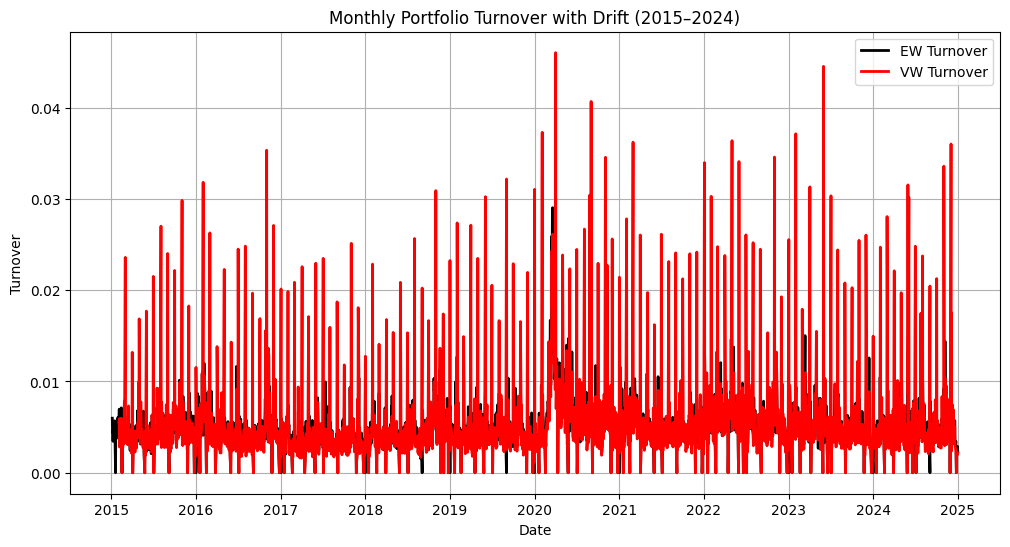

In [36]:
plt.figure(figsize=(12,6))
plt.plot(ew_turnover.index, ew_turnover, label="EW Turnover", color="black", linewidth=2)
plt.plot(vw_turnover.index, vw_turnover, label="VW Turnover", color="red", linewidth=2)

plt.title("Monthly Portfolio Turnover with Drift (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.legend()
plt.grid(True)
plt.show()

Average EW turnover (6M): 0.05911464623786752
Average VW turnover (6M): 0.033561448149027236


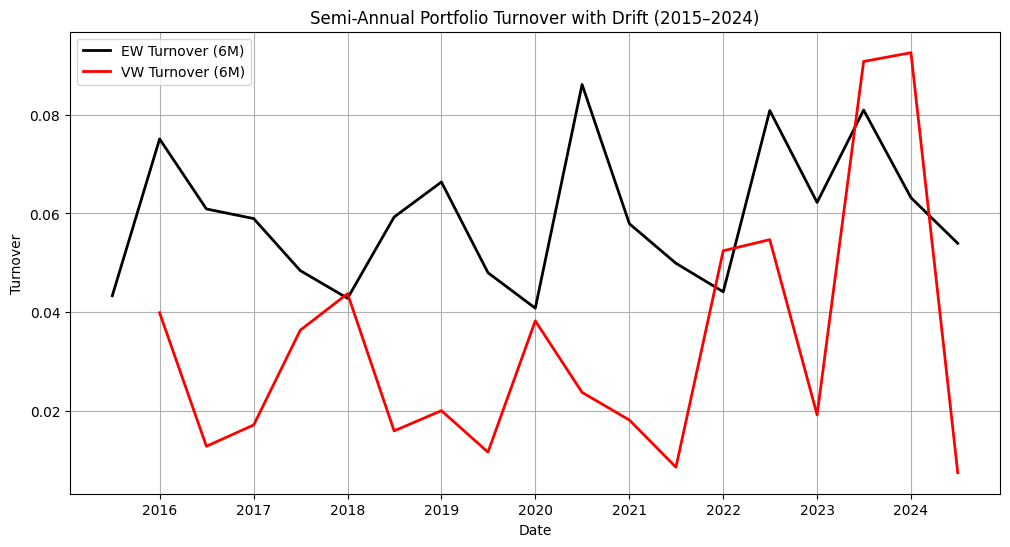

In [58]:
# --- Step 1: Get first trading day of each 6-month period ---
first_days_6m = df_returns.resample("6MS").first().index  # "6MS" = 6-month period, start

# --- Step 2: Create semi-annual EW and VW weights ---
n = len(selected)
ew_6m_weights = pd.DataFrame(1/n, index=first_days_6m, columns=selected)
ew_6m_weights = ew_6m_weights.reindex(df_returns.index, method="ffill")

vw_6m_weights = vw_monthly_weights.reindex(first_days_6m, method='nearest')
vw_6m_weights = vw_6m_weights.reindex(df_returns.index, method="ffill")

# --- Step 3: Compute turnover series using only rebalance dates ---
ew_weights_reb = ew_6m_weights.reindex(first_days_6m, method='nearest')
vw_weights_reb = vw_6m_weights.reindex(first_days_6m, method='nearest')

ew_turnover_6m = compute_turnover_with_drift(df_simple_returns, ew_weights_reb)
vw_turnover_6m = compute_turnover_with_drift(df_simple_returns, vw_weights_reb)

print("Average EW turnover (6M):", ew_turnover_6m.mean())
print("Average VW turnover (6M):", vw_turnover_6m.mean())

plt.figure(figsize=(12,6))
plt.plot(ew_turnover_6m.index, ew_turnover_6m, label="EW Turnover (6M)", color="black", linewidth=2)
plt.plot(vw_turnover_6m.index, vw_turnover_6m, label="VW Turnover (6M)", color="red", linewidth=2)

plt.title("Semi-Annual Portfolio Turnover with Drift (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.legend()
plt.grid(True)
plt.show()